In [1]:
import numpy as np
import pandas as pd
import xarray as xr


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, '../src/')
import PrimaryProductionTools as ppt


In [2]:
black=(0,0,0)
lightblue= (112/255.0,160/255.0,205/255.0)
orange=(196/255.0,121/255.0,0)
grey=(178/255.0,178/255.0,178/255.0)
darkblue=(0,52/255.0,102/255.0)
darkgreen=(0,79/255.,0)

black_shade = (128/255.0,128/255.0, 128/255.0)
lightblue_shade = (91/255.0, 174/255.0,178/255.0)
orange_shade = (204/255.0,174/255.0,113/255.0)
grey_shade = (191/255.0,191/255.0,191/255.0)
darkblue_shade = (67/255.0,147/255.0,195/255.0)
darkgreen_shade =(223/255.0, 237/255.0,195/255.0)

In [3]:
import matplotlib 
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
matplotlib.rcParams.update({'font.size': 14})

# sg643 - 2018 

In [4]:
# import data 

ds_643 = xr.open_dataset('../data/seaglider/sg643/sg643_optics_v16042021.nc')
dive_time=ppt.time_average_per_dive(ds_643.dives,ds_643.time)

time=np.unique(dive_time)
x=ds_643.dives
y=ds_643.depth


In [5]:
x=ds_643.dives
y=ds_643.depth
mld_smooth= ppt.mixed_layer_depth(x,y, ds_643.rho, thresh=0.03, return_as_mask=False).rolling(10,min_periods=3).mean()

In [6]:
time_offset=pd.Timedelta('3 hours')
sunrise,sunset=ppt.sunset_sunrise(ds_643.time,ds_643.latitude,ds_643.longitude)


ds_643['sunrise']=xr.DataArray(sunrise,dims='ctd_data_point')
ds_643['sunset']=xr.DataArray(sunset,dims='ctd_data_point')
ds_643=ds_643.set_coords('sunset')
ds_643=ds_643.set_coords('sunrise')


# find daytime measurements
ds_copy=ds_643
daydives=[]
day_time_time = []

for dive in np.unique(ds_copy.dives)[:]:
    i = x == dive
    
    subtime=ds_copy.time[i]
    subSR=ds_copy.sunrise[i]
    subSN=ds_copy.sunset[i]

    y=ds_copy.depth[i]

    light_ind=(subtime>subSR+time_offset)&(subtime<subSN-time_offset)
    if (light_ind).any() == True:
        daydives.append(True)
        
        day_time_time.append(subtime[-1].values)

    else:
        daydives.append(False)

daydives=np.array(daydives)

In [7]:
# daylength in hours
dl = ds_643.sunset-ds_643.sunrise
ds_643['dl']=dl.astype('float').values
# xr.DataArray(dl.astype('float').values,coords=[("ctd_data_point", ds_643.ctd_data_point)])

custom_bin = np.r_[
    np.arange(0, 200, 1.0),
]

dl_grd=ppt.pandas_grid(ds_643['dl'],ds_643.dives,ds_643.depth,bins=custom_bin).iloc[:,daydives==True]

td=pd.to_timedelta(pd.Series(np.nanmean(dl_grd,axis=0)))
td=td.dt.round('1h')
dl=td.dt.components.hours

par=ppt.pandas_grid(ds_643.par_clean,ds_643.dives,ds_643.depth,bins=custom_bin).iloc[:,daydives==True]
pars=(np.nanmean(par.iloc[:1,:],axis=0)*60*60*dl)/1e6  #micromol einsteins/photons
pars[pars<5]=np.nan
pars=pars.interpolate()


cphyto = ppt.compute_cphyto(ds_643.bbp700_baseline)

mld=mld_smooth.iloc[daydives==True]

In [8]:
# grid the rest of the data

cphyto_z = ppt.pandas_grid(cphyto,ds_643.dives,ds_643.depth,bins=custom_bin).iloc[:,daydives==True]
bbp_z = ppt.pandas_grid(ds_643.bbp700_baseline,ds_643.dives,ds_643.depth,bins=custom_bin).iloc[:,daydives==True]
chl_z = ppt.pandas_grid(ds_643.chl,ds_643.dives,ds_643.depth,bins=custom_bin).iloc[:,daydives==True]
ct = ppt.pandas_grid(ds_643.temperature,ds_643.dives,ds_643.depth,bins=custom_bin).iloc[:,daydives==True]


# deals with outliers and missing datapoints
cphyto_z[cphyto_z<0]=0
cphyto_z=cphyto_z.interpolate('bfill')
chl_z=chl_z.interpolate('bfill')

# compute pp _ cbpm - using glider observed PAR


In [9]:

pp_z643=np.ndarray([200,len(pars)])
mu_z=np.ndarray([200,len(pars)])
par_z=np.ndarray([200,len(pars)])
prcnt_z=np.ndarray([200,len(pars)])

for i in range(len(pars)):
    pp_z643[:,i],mu_z[:,i],par_z[:,i],prcnt_z[:,i]   = ppt.cbpm_bgcfloats(chl_z.iloc[:,i].values,
                                            cphyto_z.iloc[:,i].values,
                                            pars.iloc[i],
                                            dl.iloc[i])

# compute pp _ cbpm - using colocated satellite observed PAR


In [10]:
#repeat the same but with satellite par
#import satelite par data
sat = xr.open_dataset('../data/par/PAR_data_sg643.nc')
sat.PAR[sat.PAR<0]=np.nan
sat_PAR=sat.PAR

# put sat data in a dataframe

dfsat = pd.DataFrame({
    
                      'par':sat_PAR[daydives],
                     'glpar':pars})

# regress satellite by glider par

from sklearn.linear_model import LinearRegression

X = np.array(dfsat.glpar.values)
Y = np.array(dfsat.par.values)
mask = ~np.isnan(X)&~np.isnan(Y)

X= X[mask].reshape(-1,1)
Y =Y[mask].reshape(-1,1)
linear_regressor = LinearRegression(fit_intercept=False)
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)


slope=linear_regressor.coef_
intercept = linear_regressor.intercept_
r2=linear_regressor.score(X,Y)
print(intercept)
print(r2)

sat_PAR=sat_PAR.values
sat_PAR=pd.Series(sat_PAR[daydives]).interpolate()
# sat_PAR=pd.Series(sat_PAR).interpolate()


sat_PAR_adj=[]
for i in range(len(sat_PAR)):
#     if sat_PAR[i]>pars[i]:
#     if sat_PAR[i]>intercept:
    if sat_PAR[i]>0:


#         sat_PAR_adj.append(sat_PAR[i]-intercept)
        sat_PAR_adj.append(sat_PAR[i]/slope)

    else:
        sat_PAR_adj.append(sat_PAR[i])
        
sat_PAR_adj=np.array(sat_PAR_adj)
sat_PAR_adj[sat_PAR_adj<0]=np.nan
sat_PAR_adj=pd.Series(sat_PAR_adj).interpolate()

0.0
-0.9788352765277746


In [11]:
pp_z_sat643=np.ndarray([200,len(pars)])
mu_z_sat=np.ndarray([200,len(pars)])
par_z_sat=np.ndarray([200,len(pars)])
prcnt_z_sat=np.ndarray([200,len(pars)])

for i in range(len(pars)):
    pp_z_sat643[:,i],mu_z_sat[:,i],par_z_sat[:,i],prcnt_z_sat[:,i]   = ppt.cbpm_bgcfloats(chl_z.iloc[:,i].values,
                                                                        cphyto_z.iloc[:,i].values,
                                                                            sat_PAR_adj.iloc[i],
                                                                                dl.iloc[i])
                                            
                                                                                      


In [12]:
int_pp_sat=np.ndarray(len(mld))
int_pp_glider = np.ndarray(len(mld))
for i in range(len(mld)):
    int_pp_sat[i] = np.nansum(pp_z_sat643[:,i],0)   
    int_pp_glider[i] = np.nansum(pp_z643[:,i],0)
    
int_pp_sat[int_pp_sat==0]=np.nan
int_pp_sat=pd.Series(int_pp_sat).interpolate()


int_pp_glider[int_pp_glider==0]=np.nan
int_pp_glider = pd.Series(int_pp_glider).interpolate()
    

In [13]:
# PP per day
# dive_time=gt.utils.time_average_per_dive(ds_643.dives[ds_643.dives<503.5],ds_643.time)
# time643=np.unique(dive_time)[daydives]

df_pp = pd.DataFrame({'time':time[daydives],
                     'sat_pp':int_pp_sat,
                     'glider_pp':int_pp_glider,
#                      'surface_cbpm':npp_cbpm,
#                       'surface_vgpm':npp_vgpm,
                     'mld':mld.values})

df_pp=df_pp.set_index('time')
dailyPP=df_pp.resample('D').max().rolling(2).mean()

Text(0.02, 0.85, 'd')

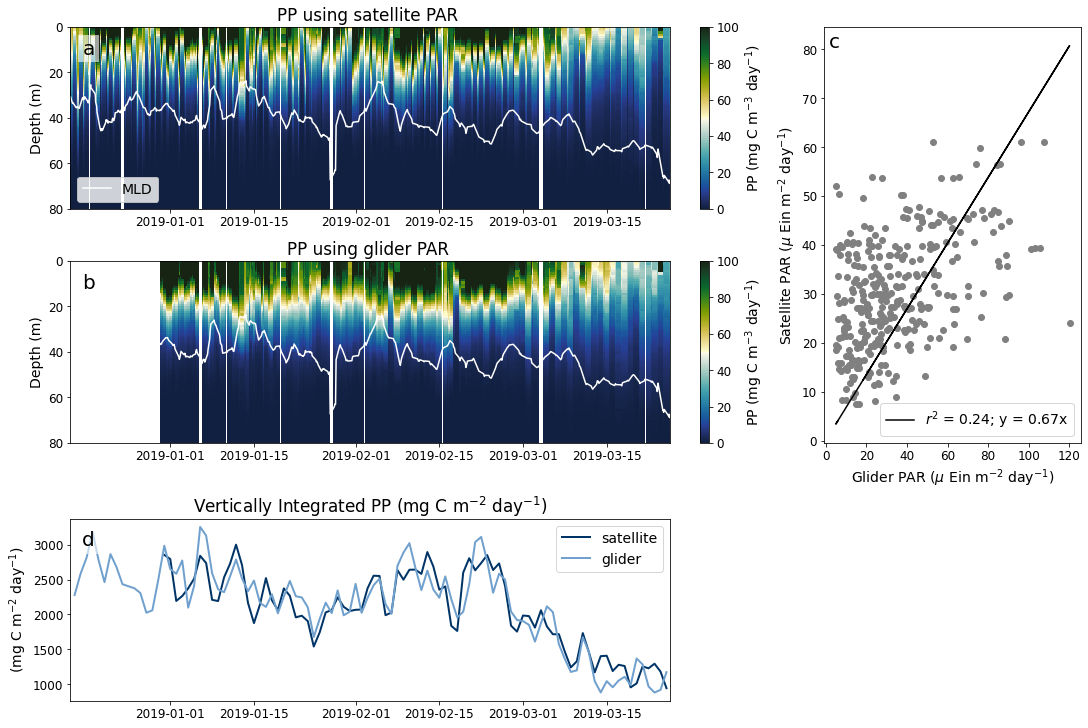

In [14]:
import cmocean.cm as cmo

import matplotlib.gridspec as gridspec
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
years = YearLocator()   # every year
months = MonthLocator()  # every month
monthsFmt = DateFormatter('%b')

fig = plt.figure(constrained_layout=True,figsize=[15,10])
gs = gridspec.GridSpec(3, 2, figure=fig,width_ratios=[0.7,0.3])

ax1 = plt.subplot(gs[0,0])#,projection=projection)
ax2 = plt.subplot(gs[:2,1])#,projection=projection)
ax3 = plt.subplot(gs[1,0],sharex=ax1)
ax5 = plt.subplot(gs[2,0],sharex=ax1)
# ax6 = plt.subplot(gs[2,1])


xx,yy=np.meshgrid(time[daydives],np.arange(0,200,1))

cs1=ax1.pcolormesh(xx,yy,pp_z643,vmin=0,vmax=100,cmap=cmo.delta)
ax1.plot(time[daydives],mld,'w',label='MLD')
ax1.set_ylim(80,0)
cbar = plt.colorbar(cs1,ax=ax1)
cbar.set_label('PP (mg C m$^{-3}$ day$^{-1}$)')
ax1.legend(loc='lower left')


cs2=ax3.pcolormesh(xx,yy,pp_z_sat643,vmin=0,vmax=100,cmap=cmo.delta)
ax3.set_ylim(80,0)
ax3.plot(time[daydives],mld,'w',label='mld')

cbar2=plt.colorbar(cs1,ax=ax3)
cbar2.set_label('PP (mg C m$^{-3}$ day$^{-1}$)')

ax5.plot(dailyPP.index,dailyPP.sat_pp,lw=2,label='satellite',c=darkblue)
ax5.plot(dailyPP.index,dailyPP.glider_pp,lw=2,label='glider',c=lightblue)
ax5.legend()

ax5.set_ylabel('(mg C m$^{-2}$ day$^{-1}$)')

# ax2.plot(X,Y_pred,c='k',label='$\it{r^2}$ = 0.24; y={}x+{}'.format(np.round(linear_regressor.coef_,2),np.round(linear_regressor.intercept_,2)))
ax2.plot(X,Y_pred,c='k',label='$\it{r^2}$ = 0.24; y = 0.67x')#.format(np.round(linear_regressor.coef_,2),np.round(linear_regressor.intercept_,2)))

ax2.scatter(X,Y,c='grey')
ax2.legend(loc='lower right')
ax2.set_ylabel('Satellite PAR ($\mu$ Ein m$^{-2}$ day$^{-1}$)')
ax2.set_xlabel('Glider PAR ($\mu$ Ein m$^{-2}$ day$^{-1}$)')

ax1.set_ylabel('Depth (m)')
ax3.set_ylabel('Depth (m)')

ax5.set_title('Vertically Integrated PP (mg C m$^{-2}$ day$^{-1}$)')
ax1.set_title('PP using satellite PAR ')
ax3.set_title('PP using glider PAR ')

ax1.text(0.02,0.85,'a',transform=ax1.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))
ax2.text(0.02,0.95,'c',transform=ax2.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))
ax3.text(0.02,0.85,'b',transform=ax3.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))
ax5.text(0.02,0.85,'d',transform=ax5.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))
# 
# plt.savefig('../results/figures/PP_compare_par_sensors.png',dpi=150,bbox_inches='tight')

# compare PP CbPM with other PP models
- VGPM
- Eppley VGPM
- CBPM
- Platt

In [15]:
euphotic_depth, kd = ppt.photic_depth(
    ds_643.par_clean, ds_643.dives, ds_643.depth,
    return_mask=False,
    ref_percentage=1
)


kd[kd<-0.2]=np.nan

euphotic_depth[euphotic_depth>100]=np.nan
kd[daydives][kd[daydives]<-0.14]=np.nan

In [16]:
df643 = pd.DataFrame({'bbp':bbp_z.iloc[:10,:].mean(0).values,
                     'par':pars.values,
                     'chl':chl_z.iloc[:10,:].mean(0).values, 
                     'dl':dl.values,
                     'mld':mld_smooth[daydives],
                     'sst':ct.iloc[:10,:].mean(0).values,
                     'time':time[daydives]})
df643['kd']=kd[daydives].values
df643_daily=df643.set_index('time').resample('D').max()

In [17]:
npp_vgpm_eppley=np.ndarray(len(df643_daily.sst))
for i in range(len(df643_daily.sst)):
    try:
        npp_vgpm_eppley[i] = ppt.vgpm(df643_daily.chl.iloc[i], df643_daily.par.iloc[i], df643_daily.sst.iloc[i],
                            df643_daily.dl.iloc[i],'eppley')
    except: vgpm_eppley[i] = np.nan
    continue
    
npp_vgpm=np.ndarray(len(df643_daily.sst))
for i in range(len(df643_daily.sst)):
    try:
        npp_vgpm[i] = ppt.vgpm(df643_daily.chl.iloc[i], df643_daily.par.iloc[i], df643_daily.sst.iloc[i],
                            df643_daily.dl.iloc[i],'standard')
    except: vgpm[i] = np.nan
    continue
    
npp_cbpm=np.ndarray([101])
for i in range(101):
    npp_cbpm[i] = ppt.calculate_cbpm(df643_daily.bbp.iloc[i],
                                 df643_daily.par.iloc[i], 
                                 df643_daily.chl.iloc[i],
                                 df643_daily.kd.iloc[i],
                                 df643_daily.dl.values[i],
                                 df643_daily.mld.iloc[i])

In [18]:
pp=ppt.platt(df643_daily.chl.values,df643_daily.par.values,df643_daily.kd.values,df643_daily.dl.values)
pp[pp>3500]=np.nan


## Create a dataframe for all estimates of primary production

In [19]:
NPP = pd.DataFrame({
                   'cbpm_int_glider':dailyPP.glider_pp,
                   'cbpm_int_sat':dailyPP.sat_pp,
                   'cbpm_standard':npp_cbpm,
                   'vgpm_standard':npp_vgpm,
                    'vgpm_eppley':npp_vgpm_eppley,
                    'platt':pp
                   })

# save to file
NPP=NPP.to_xarray()
NPP['days_since_1Jan']=(((NPP.time.dt.dayofyear+ 180) %365)-180)
# NPP.to_netcdf('../results/data/npp_643.nc')

# sg640

Because we have elected to complete the main analysis only with the adapted cbpm PP estimates.

For this reason (and maybe I can update this at a later stage), only compute that model for sg640 in 2019

In [20]:
gliderfilename = '../data/seaglider/sg640/sg640_opticsv16042021.nc'   #import gridded product   THIS IS THE RIGHT ONE
# 
ds_640 = xr.open_dataset(gliderfilename)
dive_time=ppt.time_average_per_dive(ds_640.dives[ds_640.dives<610.5],ds_640.time)
time640=np.unique(dive_time)


x=ds_640.dives
mld_640= ppt.mixed_layer_depth(ds_640.dives,ds_640.depth, ds_640.rho, thresh=0.03, return_as_mask=False).rolling(10,min_periods=3).mean()
sunrise,sunset = ppt.sunset_sunrise(ds_640.time,ds_640.latitude,ds_640.longitude)

ds_640['sunrise']=xr.DataArray(sunrise,dims='ctd_data_point')
ds_640['sunset']=xr.DataArray(sunset,dims='ctd_data_point')
ds_640=ds_640.set_coords('sunset')
ds_640=ds_640.set_coords('sunrise')

ds_copy=ds_640
daydives640=[]
day_time_time = []

for dive in np.unique(ds_copy.dives)[:]:
    i = x == dive
    
    subtime=ds_copy.time[i]
    subSR=ds_copy.sunrise[i]
    subSN=ds_copy.sunset[i]
    y=ds_copy.depth[i]
    light_ind=(subtime>subSR+time_offset)&(subtime<subSN-time_offset)
    if (light_ind).any() == True:
        daydives640.append(True)
        
        day_time_time.append(subtime[-1].values)

    else:
        daydives640.append(False)
        

daydives640=np.array(daydives640)

dspar_640=xr.open_dataset('../data/par/PAR_data_sg640.nc')
dspar_640.PAR

PAR_640=dspar_640.PAR[daydives640[-603:]]
PAR_640[PAR_640<0]=np.nan

sat_PAR_adj = PAR_640/0.67

cphyto = ppt.compute_cphyto(ds_640.bbp_baseline)

# daylength in hours
dl = ds_640.sunset-ds_640.sunrise
ds_640['dl']=dl.astype('float').values
# xr.DataArray(dl.astype('float'),coords=[("ctd_data_point", ds_640.ctd_data_point)])
dl_grd=ppt.pandas_grid(ds_640['dl'],ds_640.dives,ds_640.depth,bins=custom_bin).iloc[:,daydives640==True].loc[:,300:1114]

td=pd.to_timedelta(pd.Series(np.nanmean(dl_grd,axis=0)))
td=td.dt.round('1h')
dl=td.dt.components.hours[:]


cphyto_z640  = ppt.pandas_grid(cphyto,ds_640.dives,ds_640.depth,bins=custom_bin).iloc[:,daydives640].loc[:,300:1114]
bbp_z640  = ppt.pandas_grid(ds_640.bbp_baseline,ds_640.dives,ds_640.depth,bins=custom_bin).iloc[:,daydives640].loc[:,300:1114]
chl_z640  = ppt.pandas_grid(ds_640.chl,ds_640.dives,ds_640.depth,bins=custom_bin).iloc[:,daydives640].loc[:,300:1114]
ct6440 = ppt.pandas_grid(ds_640.temperature,ds_640.dives,ds_640.depth,bins=custom_bin).iloc[:,daydives640].loc[:,300:1114]
cphyto_z640 [cphyto_z640 <0]=0
cphyto_z640 =cphyto_z640.interpolate('bfill')
chl_z640=chl_z640.interpolate('bfill')

df640 = pd.DataFrame({'bbp':bbp_z640.iloc[:20,:].mean(0).values,
                     'par':sat_PAR_adj,
                     'chl':chl_z640.iloc[:20,:].mean(0).values,
#                      'kd':kd[daydives].values,
                     'dl':dl.values,
                     'mld':mld_640[daydives640][300:1114].values,
                     'sst':ct6440.iloc[:20,:].mean(0).values,
                     'time':time640[-603:][daydives640[-603:]]})
df640_daily=df640.set_index('time').resample('D').max()

In [21]:
pp_z_sat=np.ndarray([200,352])
mu_z_sat=np.ndarray([200,352])
par_z_sat=np.ndarray([200,352])
prcnt_z_sat=np.ndarray([200,352])

for i in range(350):
    pp_z_sat[:,i],mu_z_sat[:,i],par_z_sat[:,i],prcnt_z_sat[:,i]   = ppt.cbpm_bgcfloats(
                                                                                    chl_z640.iloc[:,i].values,
                                                                                    cphyto_z640.iloc[:,i].values,
                                                                                    sat_PAR_adj[i],
                                                                                   df640.dl[i])
    
int_pp_sat = np.nansum(pp_z_sat[:200,:],0)
int_pp_sat[int_pp_sat==0]=np.nan
int_pp_sat = pd.Series(int_pp_sat).interpolate()

df_pp_640 = pd.DataFrame({'time':time640[-603:][daydives640[-603:]],
                     'sat_pp':int_pp_sat,
                          'mld':mld_640.iloc[-603:].values[daydives640[-603:]]
                   })

df_pp_640=df_pp_640.set_index('time')
dailyPP640=df_pp_640.resample('D').max().rolling(2).mean()

Text(0, 0.5, 'Primary Productivity mgC/m2/day')

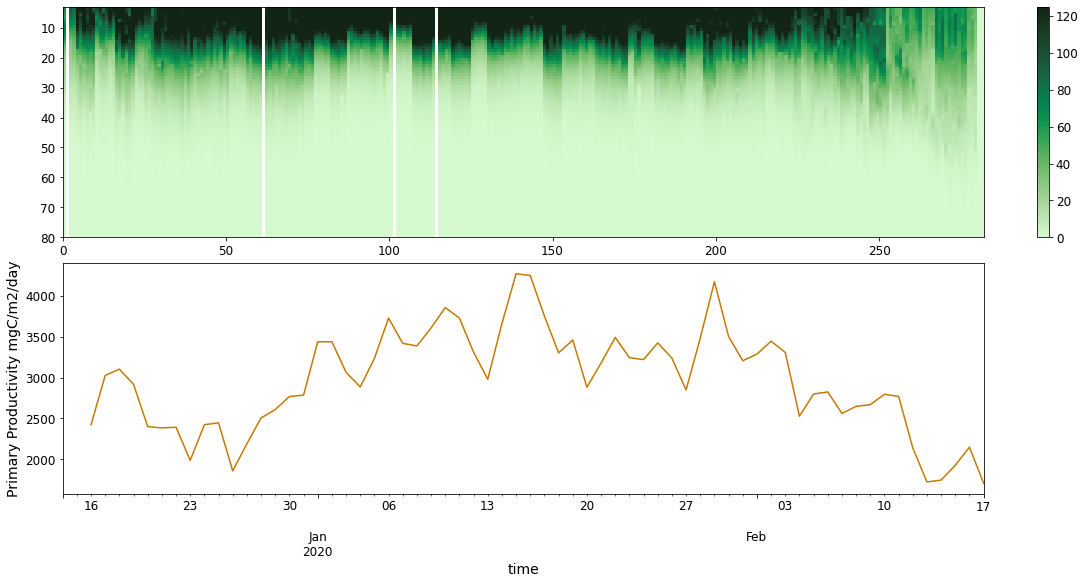

In [22]:
xx,yy=np.meshgrid(time[-533:],chl_z.index)

fig,ax=plt.subplots(2,1,figsize=[15,8],constrained_layout=True)
cs=ax[0].pcolormesh(pp_z_sat[:-1,70:],vmin=0,vmax=125,cmap=cmo.algae)
ax[0].set_ylim(80,3)
plt.colorbar(cs,ax=ax[0])

dailyPP640.sat_pp.plot(ax=ax[1],c=orange)
ax[1].set_ylabel('Primary Productivity mgC/m2/day')

# plt.savefig('sg640_PP_sat_par_altpoc.png',dpi=150,bbox_inches='tight')

In [23]:
NPP640 = pd.DataFrame({
                   'cbpm_int_sat':dailyPP640.sat_pp,

                   })
NPP640=NPP640.to_xarray()
# NPP640['days_since_1Jan']=(((NPP640.time.dt.dayofyear+ 180) %365)-180)
# save to file
# NPP640.to_netcdf('../results/data/npp_641.nc')

# NPP640.to_csv('../results/data/pp_640.csv')

In [24]:
np.nanstd(NPP640.cbpm_int_sat[16:].values)

606.0596934092863

In [25]:
np.nanmean(dailyPP640.sat_pp[15:].values)

3094.6727050935733

In [26]:
dailyPP.glider_pp.std()

586.8917674862258

In [27]:
dailyPP.glider_pp.std()

586.8917674862258

In [28]:
dailyPP.glider_pp.std()

586.8917674862258

# Comparison between the two years
 - chla
 - carbon
 - community index


### sg643

In [35]:
carbon643=np.ndarray([len(mld)])
for i in range(len(mld)):
    carbon643[i]=cphyto_z.iloc[:np.int(mld.iloc[i]),i].mean(0)

chl643=np.ndarray([len(mld)])
for i in range(len(mld)):
    chl643[i]=chl_z.iloc[:np.int(mld.iloc[i]),i].mean(0)


In [24]:
c643=chl_z.iloc[:200,:].mean(0).values

In [25]:
c643=chl_z.iloc[:200,:].mean(0).values
carbon643=cphyto_z.iloc[:30,:].mean(0).values
time643 = time[daydives]

In [36]:
df643_atten = pd.DataFrame({'time':time643,
                           'chl':chl643,
                           'carbon':carbon643})
df643_atten=df643_atten.set_index('time')

In [37]:
df643_atten.to_csv('../results/data/chlC643_mld.csv')

### SG640

In [64]:
mld_640=mld_640.iloc[daydives640].loc[300:1114]

In [77]:
carbon640=np.ndarray([len(mld_640)])
for i in range(len(mld_640)):
    carbon640[i]=cphyto_z640.iloc[:np.int(mld_640.iloc[i]),i].mean(0)

    
chl640=np.ndarray([len(mld_640)])
for i in range(len(mld_640)):
    chl640[i]=chl_z640.iloc[:np.int(mld_640.iloc[i]),i].mean(0)


In [29]:
time640 = time640[-603:][daydives640[-603:]]

In [80]:
df640_atten = pd.DataFrame({'time':time640,
                           'chl':chl640,
                           'carbon':carbon640})

In [81]:
df640_atten.to_csv('../results/data/chlC640_mld.csv')